# IMDB Top 1000 Movies EDA

Necessary packages

In [70]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
movie = pd.read_csv("/kaggle/input/imdb-dataset-of-top-1000-movies-and-tv-shows/imdb_top_1000.csv")

## Preprocessing with Univariate and Bivariate analysis on the way

### Overview

Overview of variable types, form and checking for missing values

In [20]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


In [73]:
movie.head(3)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"


Things to bear in mind:

* Released Year, Runtime, Gross are being treated as objects when it should be numeric of some sort
* Genre is a string which can contain more than one genre
* Meta_Score, Certificate and Gross have missing values
* Star1, Star2, Star3, Star4 may have to be converted to long format


Drop unnecessary columns: Poster Link, Overview

In [74]:
movie.drop(["Poster_Link", "Overview"], axis=1, inplace=True)

### Certificate

**Problem**: The variable *certificate* is not standardized, possibly because of the different rating systems across countries and epochs, therefore it depends on the nationality and release year of the film.

In [75]:
movie["Certificate"].value_counts()

Certificate
U           234
A           197
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
16            1
TV-MA         1
Unrated       1
U/A           1
Name: count, dtype: int64

**Solution**: Aggregate certificates based on the age group they are meant for, inspired by the Brazilian rating system

Looking up the different rating systems and making concessions we have the approximate mapping:

* L: PG, U, G
* 12+: U/A, TV-PG, UA, Passed, Approved
* 14+: PG-13, TV-14
* 16+: 16, A, R, TV-MA
* NaN: Unrated

Sources: 

* https://en.wikipedia.org/wiki/Motion_picture_content_rating_system
* https://en.wikipedia.org/wiki/Central_Board_of_Film_Certification
* https://en.wikipedia.org/wiki/TV_Parental_Guidelines



In [76]:
certificates = {
    "PG": "L", "U": "L", "G": "L",
    "U/A":"12+", "TV-PG":"12+", "UA": "12+", "Passed": "12+", "Approved":"12+",
    "PG-13": "14+", "TV-14":"14+",
    "16":"16+", "A":"16+", "R":"16+", "TV-MA":"16+",
    "Unrated": np.nan
}

In [77]:
movie["Certificate"] = pd.Categorical(movie["Certificate"].map(certificates), categories=["L", "12+", "14+", "16+"],
                                     ordered=True)

<Axes: xlabel='Certificate'>

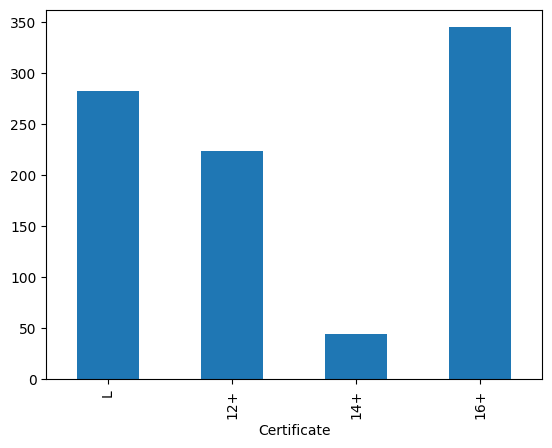

In [88]:
movie["Certificate"].value_counts().sort_index().plot(kind="bar")

Except for 14+ , there seems to be a balanced mix of ratings among the 1000 top IMDB movies. The scarcity of the 14+ badge is probably due to the concessions that had to be made to construct the mapping.

#### Certificate and Scores

<Axes: xlabel='Certificate', ylabel='Meta_score'>

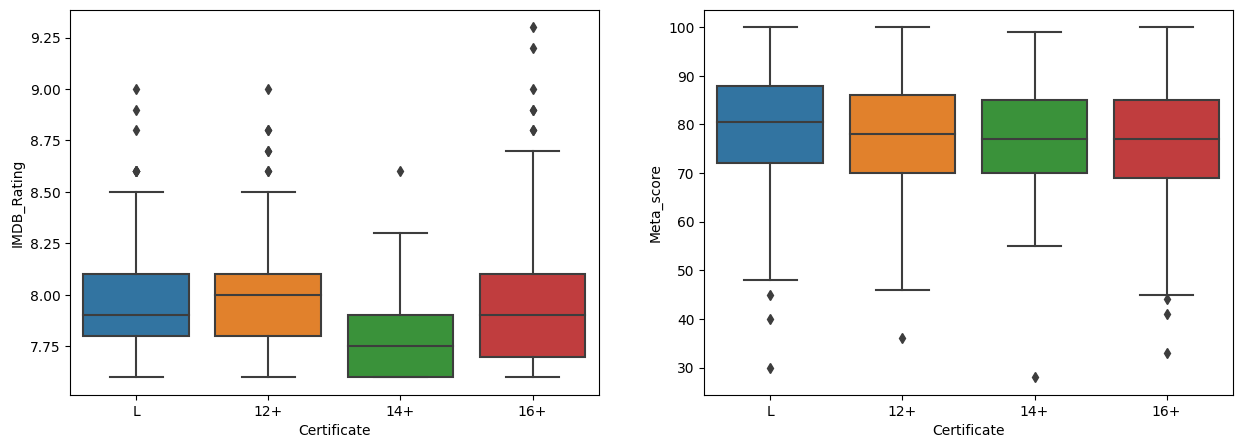

In [142]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1,2)
sns.boxplot(x="Certificate", y="IMDB_Rating", data=movie, ax=ax1)
sns.boxplot(x="Certificate", y="Meta_score", data=movie, ax=ax2)